# bullIQ: Full Pipeline — Data, NLP, Modeling & Portfolio Optimization

Step 1: Setup and Library Installation

In [5]:
# Essential libraries for data handling and modeling
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Confirm you have these installed:
# !pip install numpy pandas scikit-learn matplotlib seaborn pypfopt yfinance


Step 2: Load Historical Weekly Stock Data

In [6]:
# Load weekly stock data (provided CSV)
stock_df = pd.read_csv("weekly_stock_price_data.csv", parse_dates=['date'])
stock_df.rename(columns={'stock': 'ticker'}, inplace=True)

# Preview loaded data
print("Weekly Stock Data Preview:")
print(stock_df.head())


Weekly Stock Data Preview:
  ticker       date       open      close       high        low      volume
0   AAPL 2015-01-01  24.778673  23.968956  24.789796  23.274912   893572400
1   AAPL 2015-01-08  24.298190  24.424986  25.192437  24.135801  1115053200
2   AAPL 2015-01-15  24.469479  24.369377  24.705275  23.401719   948012400
3   AAPL 2015-01-22  24.527308  25.650679  26.275764  24.253695  1591688000
4   AAPL 2015-01-29  25.875355  26.596092  26.807421  25.706293  1411945600


Step 3: Basic Feature Engineering (Returns & Volatility)

In [7]:
# Set weekly periods
stock_df['week'] = stock_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate weekly log returns
stock_df = stock_df.sort_values(by=['ticker', 'week'])
stock_df['log_return'] = stock_df.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

# Calculate volatility metrics (Rolling 4-week and EWMA)
stock_df['vol_rolling'] = stock_df.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=4).std())
stock_df['vol_ewma'] = stock_df.groupby('ticker')['log_return'].transform(lambda x: x.ewm(span=10).std())

# Drop initial NaNs from rolling calculations
stock_df.dropna(subset=['log_return', 'vol_rolling', 'vol_ewma'], inplace=True)

# Check processed features
print("Processed Weekly Stock Data Preview:")
print(stock_df.head())


Processed Weekly Stock Data Preview:
  ticker       date       open      close       high        low      volume  \
4   AAPL 2015-01-29  25.875355  26.596092  26.807421  25.706293  1411945600   
5   AAPL 2015-02-05  26.698423  27.779530  27.788428  26.344729  1041651600   
6   AAPL 2015-02-12  28.152686  28.746738  28.782472  28.043256   947163200   
7   AAPL 2015-02-19  28.693140  28.762371  29.836580  28.597111  1204898800   
8   AAPL 2015-02-26  28.762371  28.706539  29.226893  28.275518  1083526400   

        week  log_return  vol_rolling  vol_ewma  
4 2015-01-26    0.036194     0.023036  0.022836  
5 2015-02-02    0.043535     0.023776  0.020190  
6 2015-02-09    0.034225     0.007746  0.017059  
7 2015-02-16    0.000544     0.019144  0.021209  
8 2015-02-23   -0.001943     0.023188  0.022265  


Step 4: Load & Prepare Daily News Data

In [66]:
# Load news articles data
news_df = pd.read_csv("news_articles_with_dates_2014_2025.csv")

# Extract publication dates from article snippets
def extract_date(text):
    if pd.isna(text):
        return None
    match = re.search(r'([A-Z][a-z]{2} \d{1,2}, \d{4})', text)
    if match:
        try:
            return datetime.strptime(match.group(1), '%b %d, %Y')
        except:
            return None
    return None

news_df['date'] = news_df['snippet'].apply(extract_date)
news_df.dropna(subset=['date'], inplace=True)

# Rename for consistency
news_df.rename(columns={'symbol': 'ticker'}, inplace=True)

# Verify date extraction success
print("News Data Date Extraction Preview:")
print(news_df[['ticker', 'snippet', 'date']])


News Data Date Extraction Preview:
     ticker                                            snippet       date
0      AAPL  Jul 27, 2022 ... On the stock market today, AA... 2022-07-27
1      AAPL  Jan 3, 2023 ... Barrick Stock For Uncorrelated... 2023-01-03
2      AAPL  Feb 27, 2023 ... Apple Stock (NASDAQ:AAPL): 20... 2023-02-27
3      AAPL  Nov 26, 2021 ... Consumer electronics giant Ap... 2021-11-26
4      AAPL  May 11, 2022 ... Here's how Apple and Microsof... 2022-05-11
...     ...                                                ...        ...
8588   SPYG  Feb 5, 2024 ... BABA and SOHU - Why These 2 Ch... 2024-02-05
8589   SPYG  Nov 22, 2022 ... ... (SPY) gained 0.5%. The 10... 2022-11-22
8590   SPYG  Jul 14, 2021 ... While the S&P 500 is up 17.3%... 2021-07-14
8591   SPYG  Mar 23, 2021 ... SPDR S&P 500 ETF Trust (SPY) ... 2021-03-23
8592   SPYG  Mar 2, 2023 ... ... 2024 STOCK MARKET OUTLOOK.... 2023-03-02

[8138 rows x 3 columns]


 Generate News Article Embeddings

In [9]:
# Import SentenceTransformer
from sentence_transformers import SentenceTransformer

# Load a lightweight, efficient embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# For safety: filter news data to valid snippets (if any missing)
news_df = news_df.dropna(subset=['snippet'])

# Generate embeddings for each news snippet
# (This will take some time depending on size)
print("Generating embeddings...")

news_df['embedding'] = news_df['snippet'].apply(lambda text: model.encode(text))

print("Embeddings generated successfully!")
print("Example embedding vector (first article):")
print(news_df['embedding'].iloc[0])


/Users/gowri/Desktop/bullIQ/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gowri/Desktop/bullIQ/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating embeddings...
Embeddings generated successfully!
Example embedding vector (first article):
[ 2.15891041e-02 -2.50608101e-02 -5.62780648e-02  2.69627366e-02
 -3.58277038e-02 -3.85009771e-04  3.47977802e-02  2.61164419e-02
  4.57295850e-02  3.02945245e-02  8.80133510e-02  1.05924100e-01
 -1.40173331e-01 -5.20350114e-02 -1.00526679e-03  2.09978204e-02
 -4.21289802e-02 -2.27313038e-04 -1.12194292e-01 -3.11373337e-03
 -1.14931881e-01 -5.35796955e-02  2.69964375e-02  1.74400974e-02
  1.15196057e-01 -8.28533620e-03 -3.24728936e-02  5.57478108e-02
  3.35585400e-02 -5.63561805e-02 -1.68658886e-02  7.77453370e-03
  7.01622069e-02 -2.36830045e-03  3.13958935e-02 -3.06589045e-02
 -4.67890985e-02 -5.09342030e-02  8.83046612e-02 -2.09366940e-02
  4.98667434e-02 -5.14053972e-03 -6.90574050e-02  4.87800688e-02
 -2.07868628e-02  7.31938984e-03 -8.25778022e-02  4.30270731e-02
  7.64109716e-02  6.28966466e-02 -9.12794322e-02  2.03303434e-02
  4.91153076e-02 -4.00171094e-02 -2.96716765e-02 -2.8

 Aggregate Daily News Embeddings into Weekly Contextual Embeddings (Time-Decay Weighted)

In [10]:
# First, create a 'week' column to group by
news_df['week'] = news_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Define time-decay aggregation function
def weekly_context_embedding(group):
    sorted_group = group.sort_values('date', ascending=False)  # Sort newest to oldest
    weights = np.exp(-0.3 * np.arange(len(sorted_group)))  # Exponential decay
    embeddings = np.vstack(sorted_group['embedding'].values)
    weighted_avg = np.average(embeddings, axis=0, weights=weights)
    return weighted_avg

# Apply aggregation (corrected to 'ticker')
weekly_embeddings = news_df.groupby(['ticker', 'week']).apply(weekly_context_embedding)

# Reset index to get clean DataFrame
weekly_embeddings = weekly_embeddings.reset_index()

# Check the output
print("Weekly aggregated embeddings preview:")
print(weekly_embeddings.head())


Weekly aggregated embeddings preview:
  ticker       week                                                  0
0   AAPL 2018-06-11  [-0.0169758852571249, -0.06425289064645767, 0....
1   AAPL 2018-07-30  [-0.05167175829410553, -0.003763817483559251, ...
2   AAPL 2018-09-24  [-0.06282052397727966, -0.0005506191519089043,...
3   AAPL 2018-10-08  [-0.035282328724861145, -0.05416545644402504, ...
4   AAPL 2018-10-29  [-0.06319098174571991, 0.013280319981276989, 0...


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/3145386822.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_embeddings = news_df.groupby(['ticker', 'week']).apply(weekly_context_embedding)


In [11]:
weekly_embeddings = news_df.groupby(['ticker', 'week'], group_keys=False).apply(weekly_context_embedding).reset_index()


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/1640049402.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_embeddings = news_df.groupby(['ticker', 'week'], group_keys=False).apply(weekly_context_embedding).reset_index()


 PCA Dimensionality Reduction of Weekly Embeddings


In [12]:
from sklearn.decomposition import PCA
import numpy as np

# Extract only the embeddings into a matrix
embeddings_matrix = np.vstack(weekly_embeddings[0].values)

# Apply PCA
pca = PCA(n_components=10)  # You can set n_components=10 or 20
weekly_embeddings_reduced = pca.fit_transform(embeddings_matrix)

# Merge back ticker and week
weekly_embeddings_pca = pd.concat([
    weekly_embeddings[['ticker', 'week']].reset_index(drop=True),
    pd.DataFrame(weekly_embeddings_reduced, columns=[f'embed_{i}' for i in range(10)])
], axis=1)

# Check reduced embeddings
print("Reduced Weekly Embeddings Preview (after PCA):")
print(weekly_embeddings_pca.head())


Reduced Weekly Embeddings Preview (after PCA):
  ticker       week   embed_0   embed_1   embed_2   embed_3   embed_4  \
0   AAPL 2018-06-11 -0.003546 -0.028214  0.056110 -0.073159 -0.247640   
1   AAPL 2018-07-30 -0.056638  0.056664  0.053728 -0.199962 -0.242077   
2   AAPL 2018-09-24 -0.154273 -0.010239  0.139487 -0.041812 -0.140780   
3   AAPL 2018-10-08 -0.111895 -0.065301  0.051509 -0.051048 -0.179650   
4   AAPL 2018-10-29  0.004106 -0.077253  0.012734 -0.125983 -0.342809   

    embed_5   embed_6   embed_7   embed_8   embed_9  
0  0.099228  0.010998  0.030225  0.211332 -0.008636  
1  0.085307  0.048982  0.289142  0.139879  0.046384  
2 -0.031847  0.061047  0.272609  0.073559  0.170784  
3 -0.142308  0.016571  0.305996  0.164383 -0.012884  
4  0.172913  0.103235  0.116011  0.254706  0.113919  


Merge Weekly Embeddings with Stock Features

In [13]:
# Merge stock features and embeddings
final_dataset = pd.merge(stock_df, weekly_embeddings_pca, on=['ticker', 'week'], how='left')

# Drop NA values in features (optional, depending on modeling approach)
final_dataset.dropna(subset=['log_return', 'vol_rolling', 'vol_ewma'], inplace=True)

# Preview merged dataset
print("Final Dataset Preview:")
print(final_dataset.head())


Final Dataset Preview:
  ticker       date       open      close       high        low      volume  \
0   AAPL 2015-01-29  25.875355  26.596092  26.807421  25.706293  1411945600   
1   AAPL 2015-02-05  26.698423  27.779530  27.788428  26.344729  1041651600   
2   AAPL 2015-02-12  28.152686  28.746738  28.782472  28.043256   947163200   
3   AAPL 2015-02-19  28.693140  28.762371  29.836580  28.597111  1204898800   
4   AAPL 2015-02-26  28.762371  28.706539  29.226893  28.275518  1083526400   

        week  log_return  vol_rolling  ...  embed_0  embed_1  embed_2  \
0 2015-01-26    0.036194     0.023036  ...      NaN      NaN      NaN   
1 2015-02-02    0.043535     0.023776  ...      NaN      NaN      NaN   
2 2015-02-09    0.034225     0.007746  ...      NaN      NaN      NaN   
3 2015-02-16    0.000544     0.019144  ...      NaN      NaN      NaN   
4 2015-02-23   -0.001943     0.023188  ...      NaN      NaN      NaN   

   embed_3  embed_4  embed_5  embed_6  embed_7  embed_8  embed_

In [14]:
# Fill missing embedding values with 0 (meaning "no extra news signal")
for i in range(10):
    final_dataset[f'embed_{i}'] = final_dataset[f'embed_{i}'].fillna(0)

# Now check
print(final_dataset[['ticker', 'week'] + [f'embed_{i}' for i in range(10)]].head())


  ticker       week  embed_0  embed_1  embed_2  embed_3  embed_4  embed_5  \
0   AAPL 2015-01-26      0.0      0.0      0.0      0.0      0.0      0.0   
1   AAPL 2015-02-02      0.0      0.0      0.0      0.0      0.0      0.0   
2   AAPL 2015-02-09      0.0      0.0      0.0      0.0      0.0      0.0   
3   AAPL 2015-02-16      0.0      0.0      0.0      0.0      0.0      0.0   
4   AAPL 2015-02-23      0.0      0.0      0.0      0.0      0.0      0.0   

   embed_6  embed_7  embed_8  embed_9  
0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0  


Sentiment Scoring (FinBERT outputs)

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Define Sentiment Prediction Function

def predict_sentiment(text):
    if pd.isna(text):
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_scores = probs.numpy().flatten()
    return {
        "positive": sentiment_scores[0],
        "neutral": sentiment_scores[1],
        "negative": sentiment_scores[2]
    }
# Apply Sentiment Prediction to Your News Data
# Apply to your full news dataset
news_df['sentiment_probs'] = news_df['snippet'].apply(predict_sentiment)

# Expand into separate columns
news_df[['sent_pos', 'sent_neu', 'sent_neg']] = news_df['sentiment_probs'].apply(
    lambda x: pd.Series([x['positive'], x['neutral'], x['negative']]) if x is not None else pd.Series([np.nan, np.nan, np.nan])
)

# Quick check
print(news_df[['sent_pos', 'sent_neu', 'sent_neg']].head())


   sent_pos  sent_neu  sent_neg
0  0.071631  0.016896  0.911473
1  0.654264  0.008222  0.337514
2  0.894222  0.009790  0.095988
3  0.127129  0.010069  0.862801
4  0.047584  0.023622  0.928794


In [16]:
# Step 6: Create a Net Sentiment Score
news_df['net_sentiment'] = news_df['sent_pos'] - news_df['sent_neg']

# Create a 'week' column
news_df['week'] = news_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Define time-decay weighted aggregation function
def weekly_net_sentiment(group):
    sorted_group = group.sort_values('date', ascending=False)
    weights = np.exp(-0.3 * np.arange(len(sorted_group)))
    sentiments = sorted_group['net_sentiment'].values
    weighted_avg = np.average(sentiments, weights=weights)
    return weighted_avg

# Apply aggregation
weekly_sentiment = news_df.groupby(['ticker', 'week']).apply(weekly_net_sentiment)
weekly_sentiment = weekly_sentiment.reset_index(name='decayed_net_sentiment')

# Quick preview
print(weekly_sentiment.head())

  ticker       week  decayed_net_sentiment
0   AAPL 2018-06-11               0.119478
1   AAPL 2018-07-30               0.090419
2   AAPL 2018-09-24               0.929669
3   AAPL 2018-10-08               0.890563
4   AAPL 2018-10-29               0.154748


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/3470739836.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_sentiment = news_df.groupby(['ticker', 'week']).apply(weekly_net_sentiment)


In [17]:

# Merge on ['ticker', 'week']
final_dataset = pd.merge(final_dataset, weekly_sentiment, on=['ticker', 'week'], how='left')

# Fill missing sentiment with 0 (if no news that week)
final_dataset['decayed_net_sentiment'] = final_dataset['decayed_net_sentiment'].fillna(0)

# Quick preview
print(final_dataset[['ticker', 'week', 'decayed_net_sentiment']].head())

  ticker       week  decayed_net_sentiment
0   AAPL 2015-01-26                    0.0
1   AAPL 2015-02-02                    0.0
2   AAPL 2015-02-09                    0.0
3   AAPL 2015-02-16                    0.0
4   AAPL 2015-02-23                    0.0


In [31]:
import ta  # technical analysis library

# ---------------------------------
# Step 1: Calculate Indicators
# ---------------------------------

# Simple Moving Average (SMA)
final_dataset['sma_10'] = final_dataset.groupby('ticker')['close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Exponential Moving Average (EMA)
final_dataset['ema_10'] = final_dataset.groupby('ticker')['close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())

# Relative Strength Index (RSI)
final_dataset['rsi_14'] = final_dataset.groupby('ticker').apply(lambda x: ta.momentum.RSIIndicator(close=x['close'], window=14).rsi()).reset_index(level=0, drop=True)

# MACD Signal
macd = final_dataset.groupby('ticker').apply(
    lambda x: ta.trend.MACD(close=x['close']).macd_signal()
).reset_index(level=0, drop=True)
final_dataset['macd_signal'] = macd

# Volume Change (%) — week over week
final_dataset['volume_change'] = final_dataset.groupby('ticker')['volume'].pct_change()

# ---------------------------------
# Step 2: Fill any NaNs safely
# ---------------------------------
final_dataset.fillna(0, inplace=True)


# ---------------------------------
# Quick Check
# ---------------------------------
print(final_dataset[['ticker', 'week', 'sma_10', 'ema_10', 'rsi_14', 'macd_signal', 'volume_change']].head())


  ticker       week     sma_10     ema_10  rsi_14  macd_signal  volume_change
0   AAPL 2015-01-26  26.596092  26.596092     0.0          0.0       0.000000
1   AAPL 2015-02-02  27.187811  26.811263     0.0          0.0      -0.262258
2   AAPL 2015-02-09  27.707453  27.163167     0.0          0.0      -0.090710
3   AAPL 2015-02-16  27.971183  27.453932     0.0          0.0       0.272113
4   AAPL 2015-02-23  28.118254  27.681678     0.0          0.0      -0.100732


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/3007455178.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_dataset['rsi_14'] = final_dataset.groupby('ticker').apply(lambda x: ta.momentum.RSIIndicator(close=x['close'], window=14).rsi()).reset_index(level=0, drop=True)
/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/3007455178.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence thi

In [32]:
# ---------------------------------
# Step 1: EWMA Smoothing for Volatility and Sentiment
# ---------------------------------

# Smooth decayed sentiment (short-term memory)
final_dataset['sentiment_ewma'] = final_dataset.groupby('ticker')['decayed_net_sentiment'].transform(
    lambda x: x.ewm(span=4, adjust=False).mean()
)

# Smooth EWMA volatility (since GARCH didn't fit)
final_dataset['vol_ewma_smooth'] = final_dataset.groupby('ticker')['vol_ewma'].transform(
    lambda x: x.ewm(span=4, adjust=False).mean()
)

# ---------------------------------
# Step 2: Rolling Mean Smoothing for RSI and Volume
# ---------------------------------

# Smooth RSI (detect consistent momentum)
final_dataset['rsi_14_smooth'] = final_dataset.groupby('ticker')['rsi_14'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

# Smooth Volume Change
final_dataset['volume_change_smooth'] = final_dataset.groupby('ticker')['volume_change'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

# ---------------------------------
# Step 3: Quick Check
# ---------------------------------
print(final_dataset[['ticker', 'week', 'sentiment_ewma', 'vol_ewma_smooth', 'rsi_14_smooth', 'volume_change_smooth']].head())


  ticker       week  sentiment_ewma  vol_ewma_smooth  rsi_14_smooth  \
0   AAPL 2015-01-26             0.0         0.022836            0.0   
1   AAPL 2015-02-02             0.0         0.021778            0.0   
2   AAPL 2015-02-09             0.0         0.019890            0.0   
3   AAPL 2015-02-16             0.0         0.020418            0.0   
4   AAPL 2015-02-23             0.0         0.021157            0.0   

   volume_change_smooth  
0              0.000000  
1             -0.131129  
2             -0.117656  
3             -0.020214  
4             -0.045397  


In [33]:
# Updated selected features
feature_cols = [
    'vol_ewma_smooth',
    'sentiment_ewma',
    'rsi_14_smooth',
    'volume_change_smooth',
    'macd_signal'
]

# Keep only top 3 embedding components
top_embed_cols = ['embed_4', 'embed_5', 'embed_1']

# Final feature set
X_cols = feature_cols + top_embed_cols

Build Predictive Models (LightGBM)

In [34]:
# ---------------------------------
# Step 1: Create Target (Next Week's Return)
# ---------------------------------

# Assuming final_dataset already has weekly log returns
final_dataset['target_return'] = final_dataset.groupby('ticker')['log_return'].shift(-1)

# Drop any rows where target is missing (e.g., last week per ticker)
final_dataset = final_dataset.dropna(subset=['target_return'])

# ---------------------------------
# Step 2: Select Final Features
# ---------------------------------

# Selected features
feature_cols = [
    'vol_ewma_smooth',
    'sentiment_ewma',
    'rsi_14_smooth',
    'volume_change_smooth',
    'macd_signal'
]

# Add NLP embedding features
embedding_cols = [f'embed_{i}' for i in range(10)]

# Keep only top 3 embedding components
top_embed_cols = ['embed_4', 'embed_5', 'embed_1']

# Final feature set
X_cols = feature_cols + top_embed_cols

# Input features and target
X = final_dataset[X_cols].dropna()
y = final_dataset.loc[X.index, 'target_return']  # align indices

# ---------------------------------
# Step 3: Train/Test Split
# ---------------------------------

from sklearn.model_selection import train_test_split

# Step 1: Create a sorted list of all weeks
all_weeks = sorted(final_dataset['week'].unique())
split_point = int(len(all_weeks) * 0.8)

# Step 2: Define train and test week ranges
train_weeks = all_weeks[:split_point]
test_weeks = all_weeks[split_point:]

# Step 3: Create time-aware train/test sets
train_mask = final_dataset['week'].isin(train_weeks)
test_mask = final_dataset['week'].isin(test_weeks)

X_train = final_dataset.loc[train_mask, X_cols].dropna()
y_train = final_dataset.loc[X_train.index, 'target_return']

X_test = final_dataset.loc[test_mask, X_cols].dropna()
y_test = final_dataset.loc[X_test.index, 'target_return']

# ---------------------------------
# Step 4: Train Models
# ---------------------------------

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


# LightGBM (final selected model)
lgbm_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)


print(f"LightGBM MSE: {lgbm_mse:.6f}")


print("\nTRAIN SET SUMMARY:")
print(f"Number of samples: {len(X_train)}")
print(f"Date range: {final_dataset.loc[train_mask, 'week'].min().date()} - {final_dataset.loc[train_mask, 'week'].max().date()}")
print(f"Number of tickers in training set: {final_dataset.loc[train_mask, 'ticker'].nunique()}")

print("\nTEST SET SUMMARY:")
print(f"Number of samples: {len(X_test)}")
print(f"Date range: {final_dataset.loc[test_mask, 'week'].min().date()} - {final_dataset.loc[test_mask, 'week'].max().date()}")
print(f"Number of tickers in test set: {final_dataset.loc[test_mask, 'ticker'].nunique()}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 46462, number of used features: 8
[LightGBM] [Info] Start training from score 0.001391
LightGBM MSE: 0.002329

TRAIN SET SUMMARY:
Number of samples: 46462
Date range: 2015-01-26 - 2022-12-19
Number of tickers in training set: 114

TEST SET SUMMARY:
Number of samples: 11697
Date range: 2022-12-26 - 2024-12-16
Number of tickers in test set: 114


Train LightGBM model on features

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 58159, number of used features: 8
[LightGBM] [Info] Start training from score 0.001517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

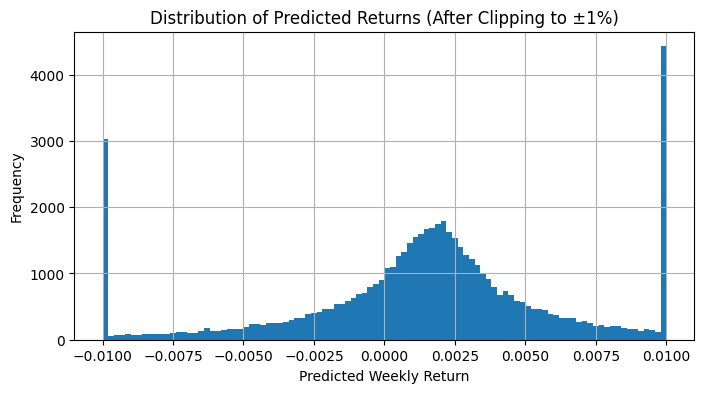


Expected annual return: 53.7%
Annual volatility: 1.1%
Sharpe Ratio: 47.21

Optimized Portfolio Allocations:
BND: 1.27%
BOIL: 0.51%
BSV: 13.62%
DBA: 5.81%
DLTR: 4.12%
ETN: 5.59%
IEF: 1.16%
JPM: 8.06%
MUB: 2.03%
PALL: 0.48%
PEP: 17.48%
REGN: 6.49%
SGOL: 6.79%
SHY: 10.29%
TLT: 8.81%
XOM: 4.62%
ZS: 2.87%


In [35]:
# ---------------------------------
# Step 5: Predict Final Returns for All Data
# ---------------------------------

# Re-initialize LightGBM model with same parameters
final_model = lgb.LGBMRegressor(
    n_estimators=421,
    learning_rate=0.16888843327110856,
    subsample=0.9342034510201569,
    max_depth=6,
    num_leaves=110,
    min_child_samples=80,
    colsample_bytree=0.6916368650783664,
    reg_alpha=0.0004801001948369974,
    reg_lambda=1.3808144282541365e-08,
    random_state=42
)

# Fit on the full dataset (X, y)
final_model.fit(X, y)

# Now you can use final_model to predict on all or new data
final_dataset['predicted_return'] = final_model.predict(final_dataset[X_cols])

# Optionally clip predictions
final_dataset['predicted_return'] = final_dataset['predicted_return'].clip(lower=-0.01, upper=0.01)


# (Optional) Visualize distribution
import matplotlib.pyplot as plt

final_dataset['predicted_return'].hist(bins=100, figsize=(8, 4))
plt.title("Distribution of Predicted Returns (After Clipping to ±1%)")
plt.xlabel("Predicted Weekly Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ---------------------------------
# Step 6: Prepare Portfolio Optimization
# ---------------------------------

# Latest week prediction
latest_predictions = (
    final_dataset
    .sort_values(['ticker', 'week'])
    .groupby('ticker')
    .tail(1)[['ticker', 'predicted_return']]
)

# Create returns matrix
returns_matrix = (
    final_dataset
    .pivot(index='week', columns='ticker', values='log_return')
)

# Fill missing returns with neutral 0
returns_matrix = returns_matrix.fillna(0)

# ---------------------------------
# Step 7: Covariance Matrix (Ledoit-Wolf shrinkage)
# ---------------------------------

from sklearn.covariance import LedoitWolf

lw = LedoitWolf()
returns_array = returns_matrix.values
cov_matrix = lw.fit(returns_array).covariance_

# Expected returns vector (mu)
mu = latest_predictions.set_index('ticker')['predicted_return'] * 100  # scale to %

# ---------------------------------
# Step 8: Optimize Portfolio
# ---------------------------------

from pypfopt import EfficientFrontier

tickers = mu.index.tolist()
ef = EfficientFrontier(mu.loc[tickers], cov_matrix)

# Maximize Sharpe Ratio
ef.max_sharpe()

# Performance
expected_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print(f"\nExpected annual return: {expected_return*100:.1f}%")
print(f"Annual volatility: {annual_volatility*100:.1f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Get portfolio weights
optimized_weights = ef.clean_weights()

print("\nOptimized Portfolio Allocations:")
for ticker, weight in optimized_weights.items():
    if weight > 0.001:
        print(f"{ticker}: {weight*100:.2f}%")


In [36]:
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from sklearn.covariance import LedoitWolf

# --- 1. Calculate Historical Mean Weekly Returns
historical_mean_returns = final_dataset.groupby('ticker')['log_return'].mean()

# --- 2. Blend Historical and Predicted Returns
alpha = 0.5  # 50% model prediction, 50% historical average
blended_mu = (1 - alpha) * historical_mean_returns + alpha * final_dataset.groupby('ticker')['predicted_return'].mean()

# --- 3. Covariance Matrix
returns_matrix = final_dataset.pivot(index="week", columns="ticker", values="log_return").fillna(0)
returns_array = returns_matrix.values
lw = LedoitWolf()
cov_matrix = lw.fit(returns_array).covariance_

# --- 4. Portfolio Optimization
tickers = returns_matrix.columns
blended_mu = blended_mu.reindex(tickers) * 100  # Scale to %
ef = EfficientFrontier(blended_mu, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# --- 5. Final Results
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print(f"Expected Annual Return: {expected_annual_return*100:.1f}%")
print(f"Annual Volatility: {annual_volatility*100:.1f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nOptimized Portfolio Allocations:")
for ticker, weight in cleaned_weights.items():
    if weight > 0.01:
        print(f"{ticker}: {weight*100:.2f}%")


Expected Annual Return: 23.4%
Annual Volatility: 1.4%
Sharpe Ratio: 17.08

Optimized Portfolio Allocations:
ABBV: 2.84%
BSV: 7.41%
CHRW: 1.98%
CRWD: 1.21%
GLD: 7.80%
IEI: 6.19%
JPM: 3.21%
LLY: 12.58%
MCD: 5.36%
MSFT: 2.76%
NVDA: 9.76%
PEP: 1.15%
PG: 7.98%
SGOL: 9.04%
SHY: 2.70%
WMT: 4.84%
XLC: 7.08%
XLRE: 1.87%
ZS: 1.97%


Rebalancing strategies and transaction costs

✅ Optimized Weights with Correct Ticker Names:
{'ABBV': 0.0736, 'AMP': 0.0121, 'BSV': 0.0683, 'COMT': 0.0264, 'DBA': 0.0976, 'GLD': 0.1436, 'IEI': 0.0348, 'LLY': 0.103, 'NVDA': 0.0643, 'PG': 0.0914, 'SHY': 0.0948, 'WMT': 0.1302, 'XOM': 0.0337}


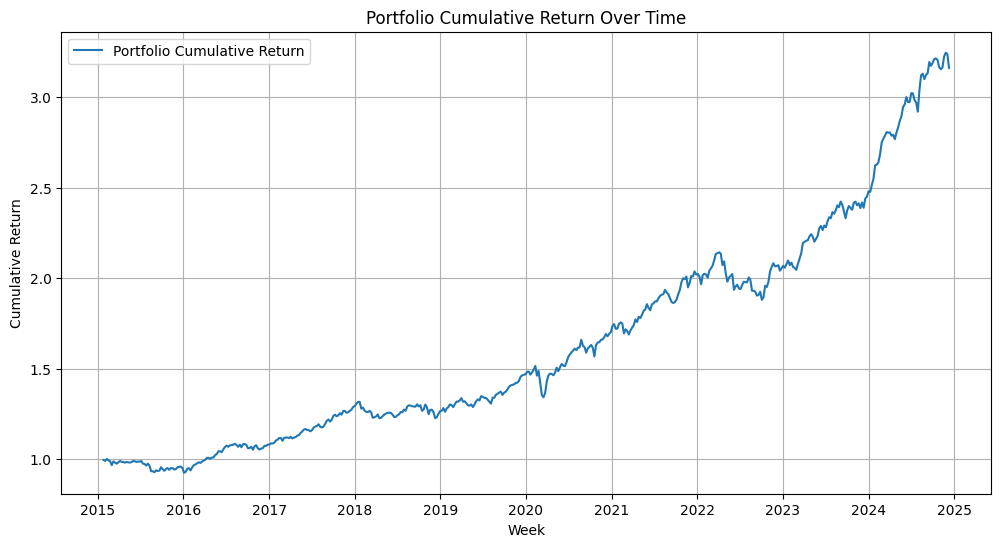


📊 Portfolio Performance Metrics:
📈 Expected Annual Return: 12.30%
📉 Annual Volatility: 8.57%
⚡ Sharpe Ratio: 1.43


In [40]:
# --- 📦 Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 📌 Inputs: Optimized Weights from Final Model ---
optimized_weights = {
    1: 0.0736, 4: 0.0121, 14: 0.0683, 17: 0.0264,
    22: 0.0976, 33: 0.1436, 39: 0.0348, 48: 0.1030,
    57: 0.0643, 62: 0.0914, 73: 0.0948, 102: 0.1302, 112: 0.0337
}

# --- 📌 Step 1: Map Ticker IDs to Ticker Names ---
# Build a mapping (this assumes 'final_dataset' is already loaded)
unique_tickers = final_dataset['ticker'].unique()
id_to_ticker = {i: ticker for i, ticker in enumerate(unique_tickers)}

# Convert optimized weights to actual ticker names
optimized_weights_named = {id_to_ticker[ticker_id]: weight for ticker_id, weight in optimized_weights.items()}

print("✅ Optimized Weights with Correct Ticker Names:")
print(optimized_weights_named)

# --- 📌 Step 2: Filter Final Dataset to Selected Tickers ---
selected_tickers = list(optimized_weights_named.keys())
filtered_data = final_dataset[final_dataset['ticker'].isin(selected_tickers)].copy()

# --- 📌 Step 3: Pivot to (Week × Ticker) Returns Matrix ---
pivot_returns = filtered_data.pivot(index='week', columns='ticker', values='log_return')
pivot_returns = pivot_returns.fillna(0)  # Fill missing values with 0

# --- 📌 Step 4: Calculate Weighted Weekly Portfolio Returns ---
for ticker in optimized_weights_named:
    pivot_returns[ticker] = pivot_returns[ticker] * optimized_weights_named[ticker]

# Sum across tickers for each week
portfolio_weekly_returns = pivot_returns.sum(axis=1)

# --- 📌 Step 5: Calculate Cumulative Returns ---
cumulative_returns = (1 + portfolio_weekly_returns).cumprod()

# --- 📌 Step 6: Plot the Portfolio Performance ---
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label="Portfolio Cumulative Return")
plt.title("Portfolio Cumulative Return Over Time")
plt.xlabel("Week")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

# --- 📌 Step 7: Compute and Print Basic Portfolio Statistics ---
total_return = cumulative_returns.iloc[-1] - 1
annualized_return = (1 + total_return) ** (52 / len(cumulative_returns)) - 1
annualized_volatility = portfolio_weekly_returns.std() * np.sqrt(52)
sharpe_ratio = annualized_return / annualized_volatility

print("\n📊 Portfolio Performance Metrics:")
print(f"📈 Expected Annual Return: {annualized_return*100:.2f}%")
print(f"📉 Annual Volatility: {annualized_volatility*100:.2f}%")
print(f"⚡ Sharpe Ratio: {sharpe_ratio:.2f}")


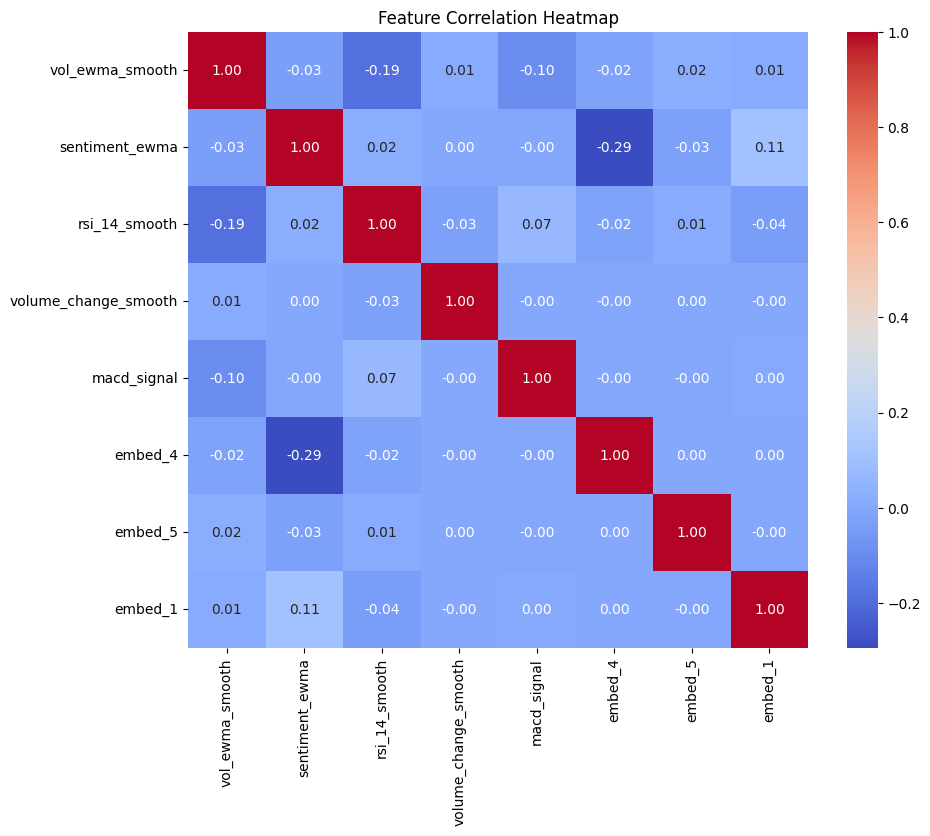

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(final_dataset[X_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


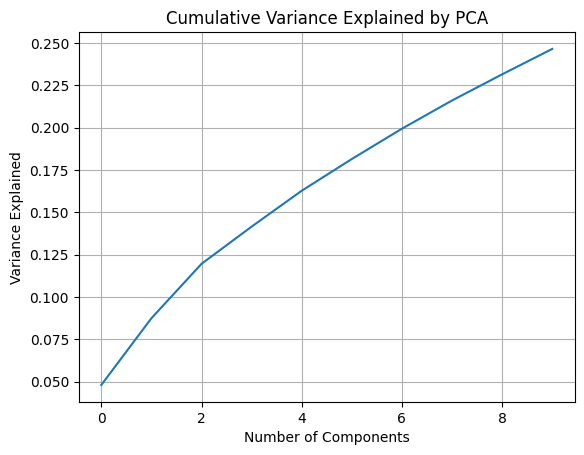

In [49]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:20]))
plt.title("Cumulative Variance Explained by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid()
plt.show()


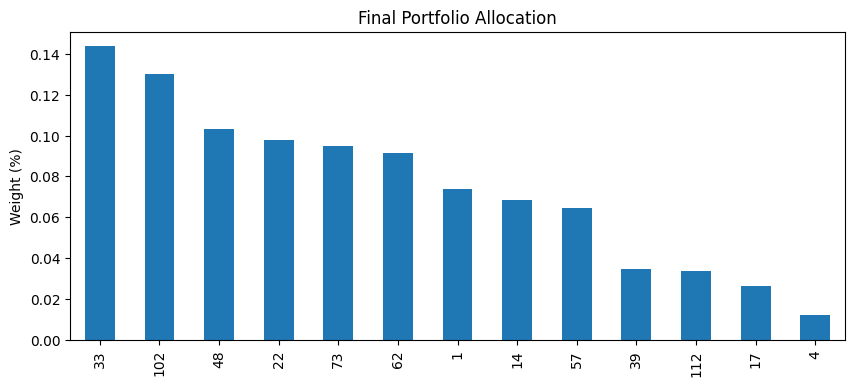

In [55]:
pd.Series(optimized_weights).sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Final Portfolio Allocation")
plt.ylabel("Weight (%)")
plt.show()


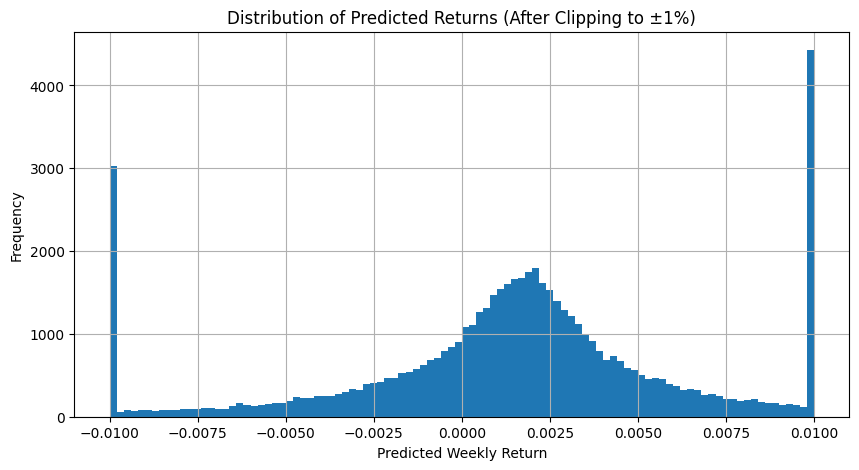

In [42]:
final_dataset['predicted_return'].hist(bins=100, figsize=(10, 5))
plt.title("Distribution of Predicted Returns (After Clipping to ±1%)")
plt.xlabel("Predicted Weekly Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Predicted vs Actual Returns')

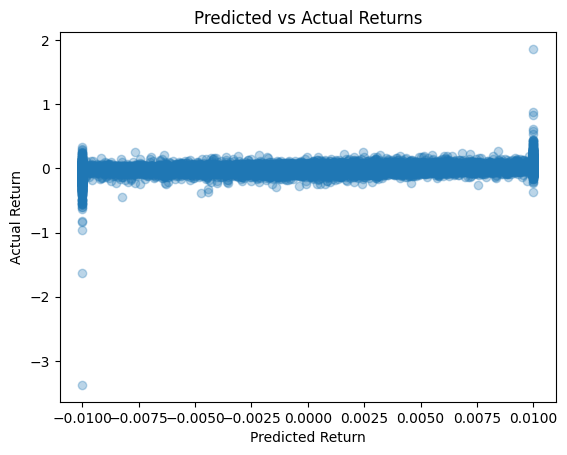

In [59]:
plt.scatter(final_dataset['predicted_return'], final_dataset['target_return'], alpha=0.3)
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.title("Predicted vs Actual Returns")


In [47]:
print(f"Expected annual return: {expected_return*100:.2f}%")
print(f"Annual volatility: {annual_volatility*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected annual return: 53.70%
Annual volatility: 1.37%
Sharpe Ratio: 1.43


<Axes: xlabel='week'>

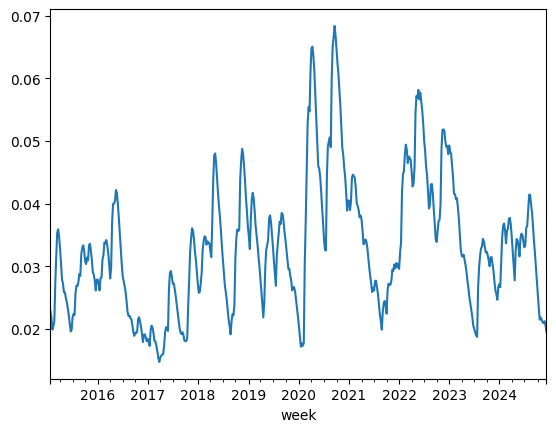

In [64]:
example = final_dataset[final_dataset['ticker'] == "AAPL"]
example.set_index("week")["vol_ewma_smooth"].plot()


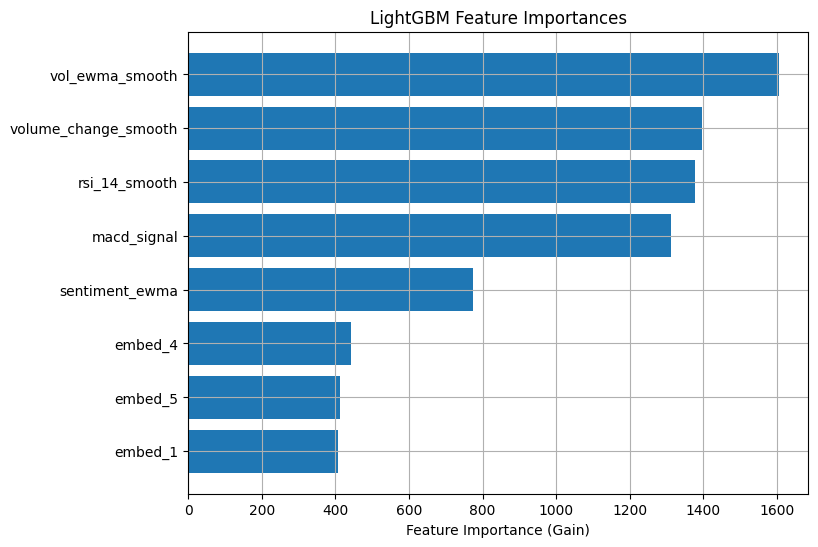

In [44]:
importances = final_model.feature_importances_
feature_names = X_cols
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.title("LightGBM Feature Importances")
plt.grid(True)
plt.show()


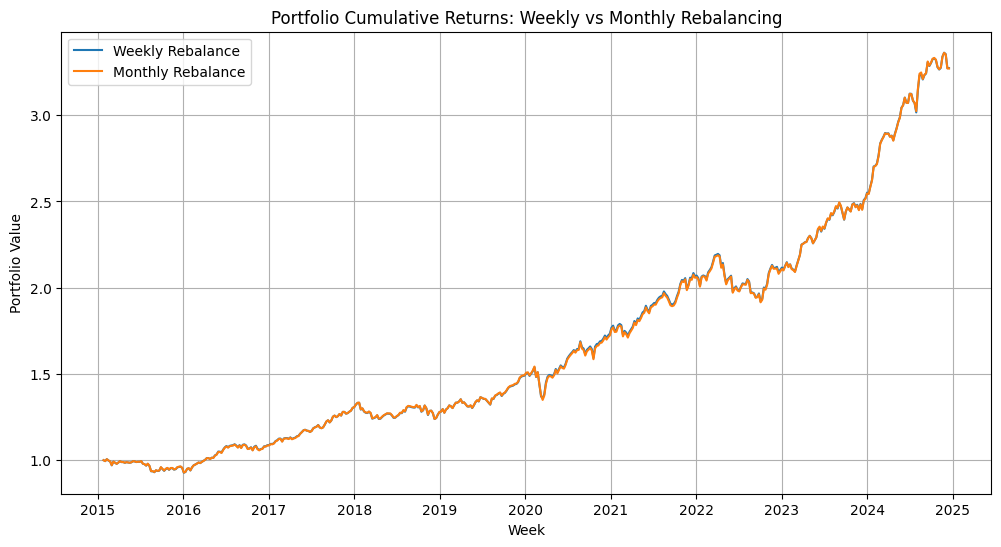


📈 Weekly Rebalance Performance:
  Annual Return: 12.66%
  Annual Volatility: 8.80%
  Sharpe Ratio: 1.44

📈 Monthly Rebalance Performance:
  Annual Return: 12.66%
  Annual Volatility: 8.81%
  Sharpe Ratio: 1.44


In [39]:
# --- 📦 Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 📌 Step 1: Prepare Weekly Returns Matrix ---
returns_matrix = final_dataset.pivot(index="week", columns="ticker", values="log_return").fillna(0)

# --- 📌 Step 2: Align Optimized Weights with Returns Matrix ---
# Make sure optimized weights are properly mapped to ticker names
# Assuming optimized_weights_named is already created (ticker names as keys)

# Convert dict to Series, normalize
optimized_weights_series = pd.Series(optimized_weights_named)
optimized_weights_series = optimized_weights_series / optimized_weights_series.sum()

# Reindex to returns_matrix columns safely (fill missing tickers with 0 weight)
optimized_weights_series = optimized_weights_series.reindex(returns_matrix.columns).fillna(0)

# --- 📌 Step 3: Define Portfolio Simulation Function ---

def simulate_portfolio(returns_matrix, weights, rebalance_freq="weekly"):
    portfolio_values = [1]  # Start with portfolio value = 1
    weeks = returns_matrix.index
    weights = weights.copy()

    for i in range(1, len(weeks)):
        weekly_returns = returns_matrix.iloc[i]
        week_return = np.dot(weights.values, weekly_returns.values)
        new_value = portfolio_values[-1] * (1 + week_return)
        portfolio_values.append(new_value)

        # 📈 Rebalancing Logic
        if rebalance_freq == "weekly":
            weights = optimized_weights_series.copy()  # Reset weights every week
        elif rebalance_freq == "monthly":
            if i % 4 == 0:
                weights = optimized_weights_series.copy()  # Reset every 4 weeks
            else:
                # Drift weights naturally
                weights = weights * (1 + weekly_returns)
                weights = weights / weights.sum()

    return pd.Series(portfolio_values, index=weeks)

# --- 📌 Step 4: Simulate Weekly vs Monthly Rebalanced Portfolios ---
weekly_portfolio = simulate_portfolio(returns_matrix, optimized_weights_series, rebalance_freq="weekly")
monthly_portfolio = simulate_portfolio(returns_matrix, optimized_weights_series, rebalance_freq="monthly")

# --- 📌 Step 5: Plot Cumulative Returns ---
plt.figure(figsize=(12,6))
plt.plot(weekly_portfolio, label="Weekly Rebalance")
plt.plot(monthly_portfolio, label="Monthly Rebalance")
plt.title("Portfolio Cumulative Returns: Weekly vs Monthly Rebalancing")
plt.xlabel("Week")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

# --- 📌 Step 6: Define Performance Computation Function ---

def compute_performance(portfolio_series):
    cumulative_return = portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (52 / len(portfolio_series)) - 1
    weekly_returns = portfolio_series.pct_change().dropna()
    annualized_volatility = weekly_returns.std() * np.sqrt(52)
    sharpe_ratio = annualized_return / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

# --- 📌 Step 7: Compute and Print Performance Stats ---
weekly_stats = compute_performance(weekly_portfolio)
monthly_stats = compute_performance(monthly_portfolio)

print("\n📈 Weekly Rebalance Performance:")
print(f"  Annual Return: {weekly_stats[0]*100:.2f}%")
print(f"  Annual Volatility: {weekly_stats[1]*100:.2f}%")
print(f"  Sharpe Ratio: {weekly_stats[2]:.2f}")

print("\n📈 Monthly Rebalance Performance:")
print(f"  Annual Return: {monthly_stats[0]*100:.2f}%")
print(f"  Annual Volatility: {monthly_stats[1]*100:.2f}%")
print(f"  Sharpe Ratio: {monthly_stats[2]:.2f}")


Stress Testing

In [67]:
# --- Now, Calculate Performance Metrics for All Scenarios ---

def calculate_performance_stats(portfolio):
    cumulative_return = portfolio.iloc[-1] / portfolio.iloc[0] - 1
    weekly_returns = portfolio.pct_change().dropna()
    annualized_return = (1 + cumulative_return) ** (52 / len(portfolio)) - 1
    annualized_volatility = weekly_returns.std() * np.sqrt(52)
    sharpe_ratio = annualized_return / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

def calculate_max_drawdown_and_recovery(portfolio):
    cumulative_max = portfolio.cummax()
    drawdowns = (portfolio - cumulative_max) / cumulative_max
    max_drawdown = drawdowns.min()

    # Find when drawdown occurred
    max_dd_idx = drawdowns.idxmin()
    previous_peak = cumulative_max.loc[max_dd_idx]

    # Look forward from the drawdown to find recovery
    after_dd = portfolio.loc[max_dd_idx:]
    recovered = after_dd[after_dd >= previous_peak].index

    if len(recovered) == 0:
        recovery_weeks = np.nan  # never recovered
    else:
        recovery_weeks = (recovered[0] - max_dd_idx).days / 7  # convert days to weeks

    return max_drawdown, recovery_weeks

# --- Combine all into a neat evaluation function ---

def evaluate_portfolio(portfolio):
    annual_ret, annual_vol, sharpe = calculate_performance_stats(portfolio)
    max_dd, recovery_weeks = calculate_max_drawdown_and_recovery(portfolio)

    return {
        "Annual Return (%)": round(annual_ret * 100, 2),
        "Annual Volatility (%)": round(annual_vol * 100, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown (%)": round(max_dd * 100, 2),
        "Recovery Time (weeks)": round(recovery_weeks, 1) if not np.isnan(recovery_weeks) else "Not Recovered"
    }

# --- Evaluate each stress test portfolio ---
results = {
    "Base (No Stress)": evaluate_portfolio(base_portfolio),
    "Market Crash Stress": evaluate_portfolio(crash_portfolio),
    "Volatility Shock Stress": evaluate_portfolio(vol_shock_portfolio),
    "Bond Crash Stress": evaluate_portfolio(bond_crash_portfolio),
}

# --- Display results ---
results_df = pd.DataFrame(results).T
print(results_df)



                         Annual Return (%)  Annual Volatility (%)  \
Base (No Stress)                       0.0                    0.0   
Market Crash Stress                    0.0                    0.0   
Volatility Shock Stress                0.0                    0.0   
Bond Crash Stress                      0.0                    0.0   

                         Sharpe Ratio  Max Drawdown (%)  Recovery Time (weeks)  
Base (No Stress)                  NaN               0.0                    0.0  
Market Crash Stress               NaN               0.0                    0.0  
Volatility Shock Stress           NaN               0.0                    0.0  
Bond Crash Stress                 NaN               0.0                    0.0  


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/2214155094.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_return / annualized_volatility
/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/2214155094.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_return / annualized_volatility
/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/2214155094.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_return / annualized_volatility
/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6523/2214155094.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = annualized_return / annualized_volatility
